<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/PartA/Assignment1/FODS_A1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle

import tqdm
from tqdm import notebook

**Loading Dataset**

In [113]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [114]:
df = pd.read_csv('/content/gdrive/My Drive/FODSAssignment/FoDS-A1.csv')
df

,Strength,Temperature,Pressure
0,30.7,240,16
1,24.7,250,18
2,30.6,260,16
3,32.8,240,10
4,20.7,240,20
...,...,...,...
1645,32.5,270,20
1646,38.6,290,14
1647,39.7,290,12
1648,14.6,200,20


Data Preprocessing

In [115]:
#shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df

,Strength,Temperature,Pressure
0,30.2,250,14
1,16.8,210,20
2,22.7,230,18
3,28.1,260,20
4,23.3,230,18
...,...,...,...
1645,22.3,230,18
1646,34.6,280,16
1647,39.8,280,14
1648,38.2,280,12


In [116]:
X_original = df.values[:,:-1]
y_original = df.values[:,-1]

In [117]:
df.describe()
mu_df = np.mean(df,axis=0)
std_df = np.std(df,axis=0)

In [118]:
# standardize the dataset
df = (df-mu_df)/std_df
df

,Strength,Temperature,Pressure
0,0.027071,0.000000,-0.29277
1,-1.786679,-1.264911,1.46385
2,-0.988088,-0.632456,0.87831
3,-0.257174,0.316228,1.46385
4,-0.906875,-0.632456,0.87831
...,...,...,...
1645,-1.042229,-0.632456,0.87831
1646,0.622631,0.948683,0.29277
1647,1.326474,0.948683,-0.29277
1648,1.109907,0.948683,-0.87831


In [ ]:
# def unstandardize(X):
#   #for x in X:
#    # x = (x*std_df + mu_df)
#   return (X*std_df + mu_df)

In [119]:
# split the data set into 70:30 train:test 
split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]


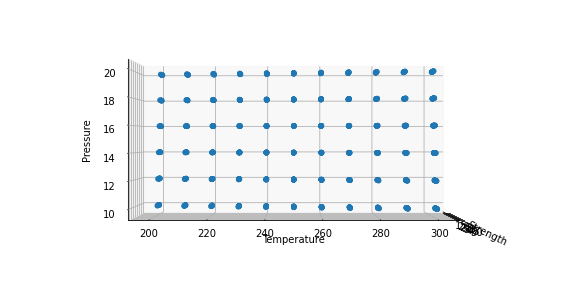

In [120]:
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(X_original[:,0], X_original[:,1], y_original)
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(0,0)

plt.show()



In [121]:
#transform the data to degree n
def transform(X,degree):
  X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
        X_trans = np.concatenate((X_trans, t.T), axis=1)
  return X_trans

In [122]:
# generate curve
def genCurve(weight,xx,yy,degree):
  #X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  Z=weight[0]
  count=0
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        count=count+1
        Z+=weight[count]*(xx**i)*(yy**j)
        #t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
        #X_trans = np.concatenate((X_trans, t.T), axis=1)
  return Z

**MODEL**

In [123]:
class Regression():

    def __init__(self, X_train, X_test, y_train, y_test):
        self.w = None
        self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])  

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn( 1,X.shape[1])    # (1,X.s...)  

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]   #[0] 
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        self.evaluate(self.X_test,self.y_test)


**0 Degree Polynomial**

In [ ]:
# transform the dataset to degree 0
x_train_trans_0 = transform(train_X,0)
x_test_trans_0 = transform(test_X,0)

Training...


  0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5021189146339171
Epoch: 50 Loss: 0.9950930052152606
Epoch: 100 Loss: 0.9784077888972602
Epoch: 150 Loss: 0.9779557310007672


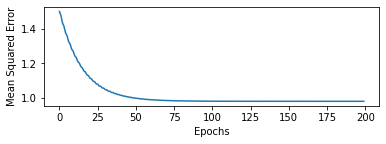

Testing
Testing Error is  1.0519845204836467


In [ ]:
# Train and Test the 0-degree regression model with Gradient Descent
GD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
GD0.fit(x_train_trans_0, train_y,epochs = 200, learning='GD', learning_rate=0.01)

In [ ]:
"""file = open('/content/gdrive/My Drive/FODSAssignment/GD0.pickle', 'wb')
pickle.dump(GD0, file)
file.close()"""

In [ ]:
 file = open('/content/gdrive/My Drive/FODSAssignment/GD0.pickle', 'rb')      #use this code
 temp = pickle.load(file)
 file.close()

In [ ]:
 wGD0 = temp.w
 wGD0
wGD0_t = unstandardize(wGD0[0])
wGD0_t

array([-0.01332315])

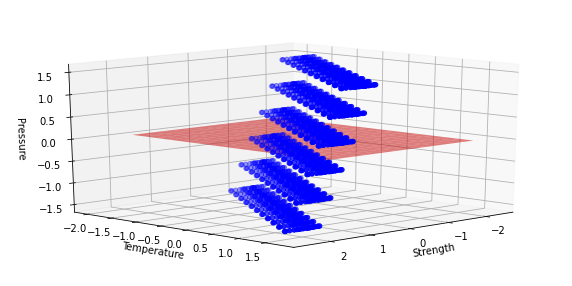

In [ ]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z = (-wGD0 * 1) #- (w[1] * yy)  + threshold )  /w[2]

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')

#ax.scatter3D(test_X[:,0],test_X[:,1],temp.predict(x_test_trans_0), c='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

Training...


  0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 4.3776116370775116
Epoch: 50 Loss: 2.2709813989361365
Epoch: 100 Loss: 1.3502645308879544
Epoch: 150 Loss: 1.1507002769827306
Epoch: 200 Loss: 1.0093672405079206
Epoch: 250 Loss: 0.984348016744303
Epoch: 300 Loss: 0.982216274459865
Epoch: 350 Loss: 0.983682471224987
Epoch: 400 Loss: 0.9779636885695441
Epoch: 450 Loss: 0.9807910392721535
Epoch: 500 Loss: 0.9794939231812685
Epoch: 550 Loss: 0.9841378277619376
Epoch: 600 Loss: 0.9864295900169082
Epoch: 650 Loss: 0.9859501663069614
Epoch: 700 Loss: 0.9800908305090767
Epoch: 750 Loss: 0.9840838579484353
Epoch: 800 Loss: 0.9903941225613353
Epoch: 850 Loss: 0.9833668456826588
Epoch: 900 Loss: 0.984905335899361
Epoch: 950 Loss: 0.983057276995097


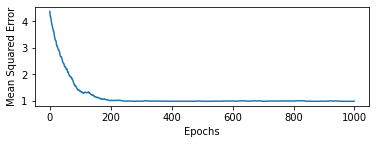

Testing
Testing Error is  1.053706772612511


In [ ]:
# Train and Test the 0-degree regression model with Stochastic Gradient Descent
SGD0 = Regression(x_train_trans_0, x_test_trans_0, train_y, test_y)
SGD0.fit(x_train_trans_0, train_y,epochs = 1000, learning='SGD', learning_rate=0.01)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD0.pickle', 'wb')
# pickle.dump(SGD0, file)
# file.close()

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD0.pickle', 'rb')      #use this code
# tempSGD0 = pickle.load(file)
# file.close()

In [ ]:
 wSGD0 = tempSGD0.w
 wSGD0

array([[-0.03296369]])

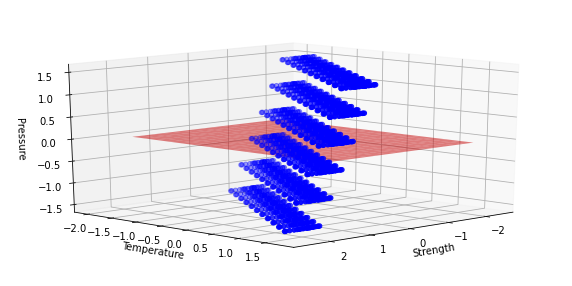

In [ ]:
# plot for 0 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z = (wSGD0 * 1) #- (w[1] * yy)  + threshold )  /w[2]

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

**1 Degree Polynomial**

In [ ]:
x_train_trans_1 = transform(train_X,1)
x_test_trans_1 = transform(test_X,1)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.7643867960397643
Epoch: 50 Loss: 0.2793193277780916
Epoch: 100 Loss: 0.20636989693365723
Epoch: 150 Loss: 0.20271806152307092
Epoch: 200 Loss: 0.20256597994729386
Epoch: 250 Loss: 0.20256701249170442
Epoch: 300 Loss: 0.20256912797324753
Epoch: 350 Loss: 0.20256971078834535
Epoch: 400 Loss: 0.20256984938183145
Epoch: 450 Loss: 0.20256988138234044


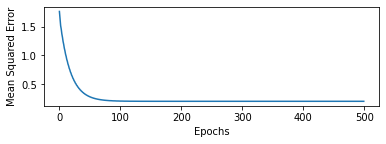

Testing
Testing Error is  0.19468872220862454


In [ ]:
GD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
GD1.fit(x_train_trans_1, train_y,epochs = 500, learning='GD', learning_rate=0.01)

In [ ]:
# file l= open('/content/gdrive/My Drive/FODSAssignment/GD1.pickle', 'wb')
# pickle.dump(GD1, file)
# file.cose()

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD1.pickle', 'rb')      #use this code
# tempGD1 = pickle.load(file)
# file.close()

In [ ]:
 wGD1 = tempGD1.w
 wGD1[0]

array([ 9.24760948e-04,  1.47368281e+00, -1.68437882e+00])

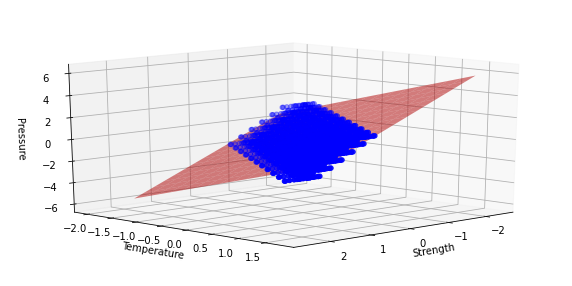

In [ ]:
# plot for 1 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD1[0],xx,yy,1)
#Z = (wGD1[0][0] * 1) + (wGD1[0][1] * yy)  + (wGD1[0][2] * xx)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 6.68044685254399
Epoch: 50 Loss: 3.1928243718200093
Epoch: 100 Loss: 1.906651452273841
Epoch: 150 Loss: 1.3250209795786323
Epoch: 200 Loss: 1.067310434645728
Epoch: 250 Loss: 0.9671162847866018
Epoch: 300 Loss: 0.8719829291550042
Epoch: 350 Loss: 0.7337824828139363
Epoch: 400 Loss: 0.629897745022932
Epoch: 450 Loss: 0.57036209656886
Epoch: 500 Loss: 0.5256355414905443
Epoch: 550 Loss: 0.47631793778154474
Epoch: 600 Loss: 0.4379089358698669
Epoch: 650 Loss: 0.42056835670835924
Epoch: 700 Loss: 0.37027991427594587
Epoch: 750 Loss: 0.3564577720263416
Epoch: 800 Loss: 0.333194272460368
Epoch: 850 Loss: 0.32509318246073454
Epoch: 900 Loss: 0.29751696110350534
Epoch: 950 Loss: 0.28302196168677407
Epoch: 1000 Loss: 0.26965718437793135
Epoch: 1050 Loss: 0.25943371065420945
Epoch: 1100 Loss: 0.25097707445606354
Epoch: 1150 Loss: 0.24448759284372784
Epoch: 1200 Loss: 0.24063595346816954
Epoch: 1250 Loss: 0.23617648542753078
Epoch: 1300 Loss: 0.22823692432163872
Epoch: 1350 Loss: 0

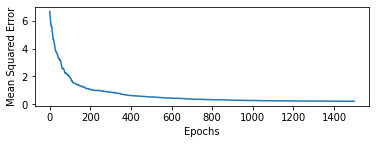

Testing
Testing Error is  0.23038992092019328


In [ ]:
SGD1 = Regression(x_train_trans_1, x_test_trans_1, train_y, test_y)
SGD1.fit(x_train_trans_1, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD1.pickle', 'wb')
# pickle.dump(SGD1, file)
# file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD1.pickle', 'rb')      #use this code
tempSGD1 = pickle.load(file)
file.close()

In [ ]:
 wSGD1 = tempSGD1.w
 wSGD1[0]

array([-0.03071567,  1.21765288, -1.48702311])

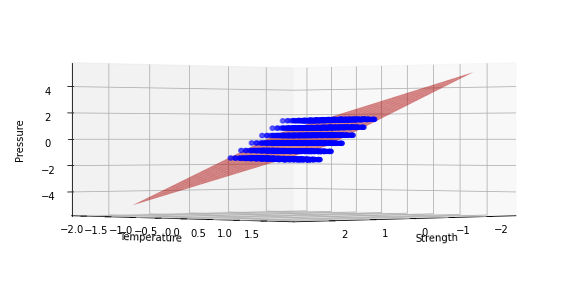

In [ ]:
# plot for 1 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD1[0],xx,yy,1)

ax.plot_surface(xx, yy, Z,alpha=0.5, color='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(0,45)

plt.show()

**2 Degree Polynomial**

In [ ]:
x_train_trans_2 = transform(train_X,2)
x_test_trans_2 = transform(test_X,2)

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 6.725039264377862
Epoch: 50 Loss: 0.20168806590761965
Epoch: 100 Loss: 0.2007337951766537
Epoch: 150 Loss: 0.20040160138429358
Epoch: 200 Loss: 0.20026166426669914
Epoch: 250 Loss: 0.20020000404906169
Epoch: 300 Loss: 0.20017135030281438
Epoch: 350 Loss: 0.2001572443918873
Epoch: 400 Loss: 0.20014990114510015
Epoch: 450 Loss: 0.20014588820493628


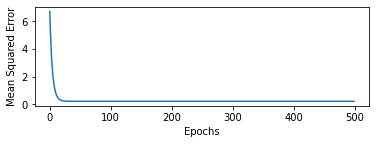

Testing
Testing Error is  0.19511671503486283


In [ ]:
GD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
GD2.fit(x_train_trans_2, train_y,epochs = 500, learning='GD', learning_rate=0.001)

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD2.pickle', 'wb')
pickle.dump(GD2, file)
file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD2.pickle', 'rb')      #use this code
tempGD2 = pickle.load(file)
file.close()

In [ ]:
 wGD2 = tempGD2.w
 wGD2

array([-0.02860394,  1.47065441,  0.12842848, -1.73783472, -0.30319409,
        0.17435725])

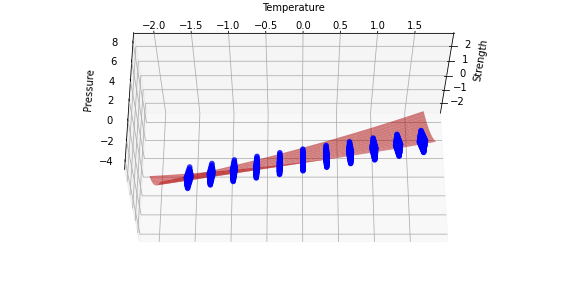

In [ ]:
# plot for 2 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
#Z = (wGD2[0][0] * 1) + (wGD2[0][1] * yy)  + (wGD1[0][2] * yy * yy) + (wGD2[0][3] * xx) + (wGD2[0][4] * xx * yy) + (wGD2[0][5] * xx * xx)
Z=genCurve(wGD2,xx,yy,2)
ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(-30,0) #(-30,0)

plt.show()

Training...


  0%|          | 0/1500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 3.9215028347528595
Epoch: 50 Loss: 2.6726828038842996
Epoch: 100 Loss: 2.294427367269647
Epoch: 150 Loss: 2.2489549616297846
Epoch: 200 Loss: 1.6994836851306823
Epoch: 250 Loss: 1.5412497017715105
Epoch: 300 Loss: 1.5536665453826433
Epoch: 350 Loss: 1.17016225784093
Epoch: 400 Loss: 0.9924263813116124
Epoch: 450 Loss: 0.8846565385407084
Epoch: 500 Loss: 0.8101327129221394
Epoch: 550 Loss: 0.7513199263663042
Epoch: 600 Loss: 0.6255653115951035
Epoch: 650 Loss: 0.5623378876539652
Epoch: 700 Loss: 0.5243624904265007
Epoch: 750 Loss: 0.46777396937674076
Epoch: 800 Loss: 0.42173824341044536
Epoch: 850 Loss: 0.42756715647761
Epoch: 900 Loss: 0.3893559678165279
Epoch: 950 Loss: 0.34915236787764914
Epoch: 1000 Loss: 0.3337880668979552
Epoch: 1050 Loss: 0.3094946080644852
Epoch: 1100 Loss: 0.29851776465961377
Epoch: 1150 Loss: 0.2828912725930047
Epoch: 1200 Loss: 0.3174831795086073
Epoch: 1250 Loss: 0.26707100919104754
Epoch: 1300 Loss: 0.26129370476189745
Epoch: 1350 Loss: 0.260

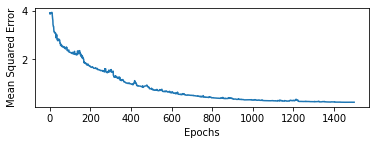

Testing
Testing Error is  0.23671740318761592


In [ ]:
SGD2 = Regression(x_train_trans_2, x_test_trans_2, train_y, test_y)
SGD2.fit(x_train_trans_2, train_y,epochs = 1500, learning='SGD', learning_rate=0.01)

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD2.pickle', 'wb')
pickle.dump(SGD2, file)
file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD2.pickle', 'rb')      #use this code
tempSGD2 = pickle.load(file)
file.close()

In [ ]:
 wSGD2 = tempSGD2.w
 wSGD2[0]

array([-0.12556793,  1.15316177,  0.32769089, -1.43880168, -0.66300541,
        0.40195067])

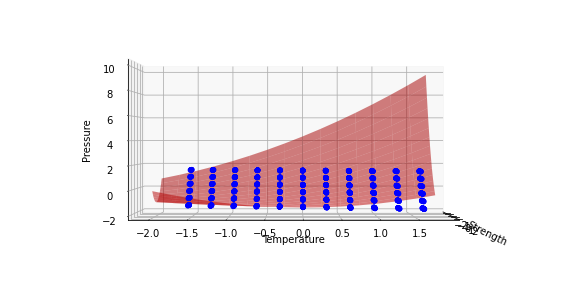

In [ ]:
# plot for 2 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD2[0],xx,yy,2)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(0,0) #(-30,0)

plt.show()

**3 Degree Polynomial**

In [ ]:
x_train_trans_3 = transform(train_X,3)
x_test_trans_3 = transform(test_X,3)


Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 1.5744551029760947
Epoch: 50 Loss: 0.23987406904963837
Epoch: 100 Loss: 0.20346105838812129
Epoch: 150 Loss: 0.19186619926558277
Epoch: 200 Loss: 0.1878145931754138
Epoch: 250 Loss: 0.1863827296574105
Epoch: 300 Loss: 0.18586071997021714
Epoch: 350 Loss: 0.18564523754628962
Epoch: 400 Loss: 0.18552787914819982
Epoch: 450 Loss: 0.18544012196574017


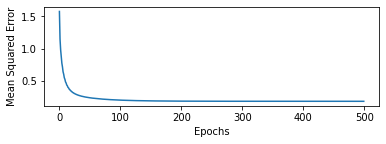

Testing
Testing Error is  0.19576571356460148


In [ ]:
GD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
GD3.fit(x_train_trans_3, train_y,epochs = 500, learning='GD', learning_rate=0.001)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD3.pickle', 'wb')
# pickle.dump(GD3, file)
# file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD3.pickle', 'rb')      #use this code
tempGD3 = pickle.load(file)
file.close()

In [ ]:
 wGD3 = tempGD3.w
 wGD3[0]

array([-0.0388043 ,  1.66270026,  0.07920001, -0.25272342, -1.97374194,
       -0.1742735 ,  1.00335352,  0.10404292, -1.19512453,  0.48306411])

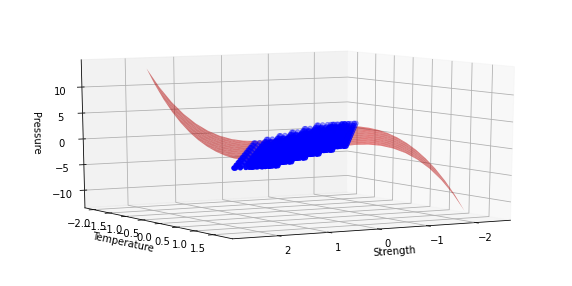

In [ ]:
# plot for 3 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD3[0],xx,yy,3)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,60) #(-30,0)

plt.show()

Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 7.123438137979889
Epoch: 50 Loss: 0.7064694604594428
Epoch: 100 Loss: 0.48465373399024475
Epoch: 150 Loss: 0.4331473479354547
Epoch: 200 Loss: 0.4684451625529419
Epoch: 250 Loss: 0.45268051735654863
Epoch: 300 Loss: 0.548253942206508
Epoch: 350 Loss: 0.3730467303554703
Epoch: 400 Loss: 0.3876718363401456
Epoch: 450 Loss: 0.2854073369124503
Epoch: 500 Loss: 0.3197968880267297
Epoch: 550 Loss: 0.39122914871212433
Epoch: 600 Loss: 6.122585127063473
Epoch: 650 Loss: 0.2819438744831445
Epoch: 700 Loss: 0.2577809020335824
Epoch: 750 Loss: 0.3020686076511504
Epoch: 800 Loss: 0.2612474621451373
Epoch: 850 Loss: 0.2921598489665734
Epoch: 900 Loss: 0.29159047254221837
Epoch: 950 Loss: 0.3295502097607922
Epoch: 1000 Loss: 0.23448897766887833
Epoch: 1050 Loss: 0.29261194162551696
Epoch: 1100 Loss: 0.30874835572542403
Epoch: 1150 Loss: 0.6921802595944462
Epoch: 1200 Loss: 0.2443405201857931
Epoch: 1250 Loss: 0.23401250199326415
Epoch: 1300 Loss: 0.27107855479260823
Epoch: 1350 Loss: 

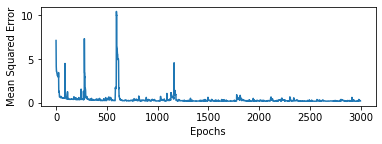

Testing
Testing Error is  0.263491283034752


In [ ]:
SGD3 = Regression(x_train_trans_3, x_test_trans_3, train_y, test_y)
SGD3.fit(x_train_trans_3, train_y,epochs = 3000, learning='SGD', learning_rate=0.01)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD3.pickle', 'wb')
# pickle.dump(SGD3, file)
# file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD3.pickle', 'rb')      #use this code
tempSGD3 = pickle.load(file)
file.close()

In [ ]:
 wSGD3 = tempSGD3.w
 wSGD3[0]

array([ 0.09141228,  1.44901652, -0.07113656, -0.11880159, -1.80091806,
        0.36486763,  0.59951064, -0.15643464, -0.79621165,  0.35502998])

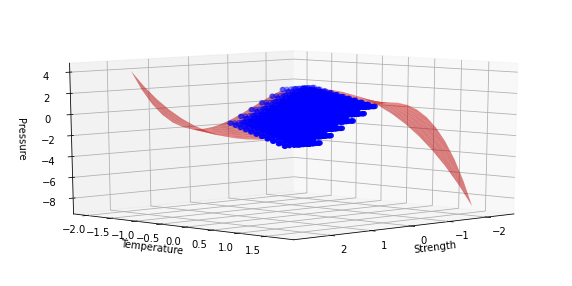

In [ ]:
# plot for 3 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD3[0],xx,yy,3)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,45) #(-30,0)

plt.show()

**4 Degree Polynomial**

In [ ]:
x_train_trans_4 = transform(train_X,4)
x_test_trans_4 = transform(test_X,4)


Training...


  0%|          | 0/700 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 22.562478994010842
Epoch: 50 Loss: 0.8191809188136185
Epoch: 100 Loss: 0.46820421649931654
Epoch: 150 Loss: 0.37240271040875017
Epoch: 200 Loss: 0.3228102445357056
Epoch: 250 Loss: 0.2915977458574706
Epoch: 300 Loss: 0.27055315309403677
Epoch: 350 Loss: 0.2558149650727552
Epoch: 400 Loss: 0.24522388043276386
Epoch: 450 Loss: 0.23746408447986622
Epoch: 500 Loss: 0.23168797156850554
Epoch: 550 Loss: 0.2273281391790216
Epoch: 600 Loss: 0.22399420921598864
Epoch: 650 Loss: 0.22141210678798934


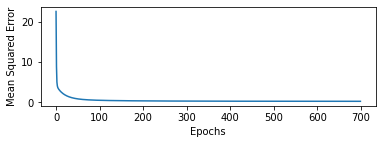

Testing
Testing Error is  0.2291862745944117


In [ ]:
GD4 = Regression(x_train_trans_4, x_test_trans_4, train_y, test_y)
GD4.fit(x_train_trans_4, train_y,epochs = 700, learning='GD', learning_rate=0.00005)

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/GD4.pickle', 'wb')
# pickle.dump(GD4, file)
# file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD4.pickle', 'rb')      #use this code
tempGD4 = pickle.load(file)
file.close()

In [ ]:
 wGD4 = tempGD4.w
 wGD4[0]

array([ 0.03640039,  1.1529497 , -0.16596893,  0.28635972,  0.19976234,
       -1.41095959,  0.20226361, -0.77212251, -0.435646  , -0.08763881,
        0.79614001,  0.14894323, -0.297704  ,  0.15208207, -0.06541936])

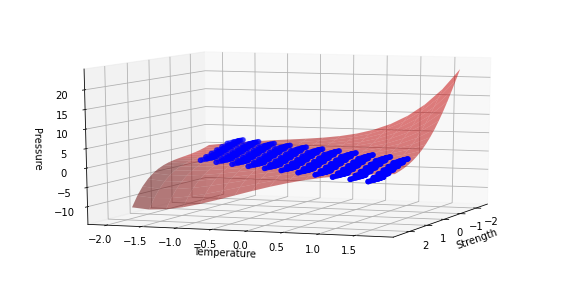

In [ ]:
# plot for 4 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD4[0],xx,yy,4)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,20) #(-30,0)

plt.show()

Training...


  0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 13.231213806765904
Epoch: 50 Loss: 3.513688197572162
Epoch: 100 Loss: 1.2115501530183352
Epoch: 150 Loss: 1.3407526853561034
Epoch: 200 Loss: 0.9234646156219697
Epoch: 250 Loss: 1.0974316709703105
Epoch: 300 Loss: 1.591747494518014
Epoch: 350 Loss: 7.580302976896574
Epoch: 400 Loss: 2.261636721669953
Epoch: 450 Loss: 0.6709131074911943
Epoch: 500 Loss: 0.6280027051942741
Epoch: 550 Loss: 0.6994321291400003
Epoch: 600 Loss: 0.6421234654237812
Epoch: 650 Loss: 0.5957900387017204
Epoch: 700 Loss: 0.6723344214668685
Epoch: 750 Loss: 0.6159450323665097
Epoch: 800 Loss: 0.6526239467724599
Epoch: 850 Loss: 0.6168906453957008
Epoch: 900 Loss: 0.544652499703573
Epoch: 950 Loss: 0.5300237594934882
Epoch: 1000 Loss: 0.5219874241972735
Epoch: 1050 Loss: 0.5406631422939816
Epoch: 1100 Loss: 0.5183514338277995
Epoch: 1150 Loss: 0.54924469473602
Epoch: 1200 Loss: 0.5313828923895133
Epoch: 1250 Loss: 0.549764861785412
Epoch: 1300 Loss: 0.556744969363221
Epoch: 1350 Loss: 0.5139692090595

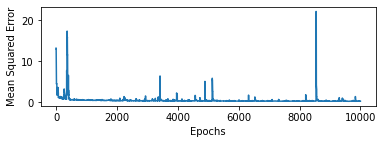

Testing
Testing Error is  0.27927910469624545


In [ ]:
SGD4 = Regression(x_train_trans_4, x_test_trans_4, train_y, test_y)
SGD4.fit(x_train_trans_4, train_y,epochs = 10000, learning='SGD', learning_rate=0.002)

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD4.pickle', 'wb')
pickle.dump(SGD4, file)
file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD4.pickle', 'rb')      #use this code
tempSGD4 = pickle.load(file)
file.close()

In [ ]:
 wSGD4 = tempSGD4.w
 wSGD4[0]

array([-0.26552119,  1.23498701,  0.57408481,  0.25776338,  0.08947492,
       -1.64473485, -1.92169717,  0.01014919, -0.06877406,  1.45305002,
       -0.63606004, -0.62676867,  0.42246738,  1.28281961, -0.6351566 ])

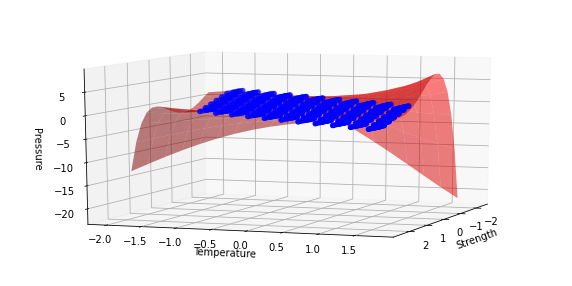

In [ ]:
# plot for 4 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD4[0],xx,yy,4)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,20) #(-30,0)

plt.show()

**MODIFIED MODEL**

In [ ]:
import math

In [ ]:
class PolynomialRegression():

    def __init__(self, degree):
        self.w = None
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degre d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int)
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/(len(y))

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn(1, X.shape[1])     

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]  
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        #self.evaluate(self.X_test,self.y_test)

**5 Degree Polynomial**

In [ ]:
#x_train_trans_5 = transform(train_X,5)
#x_test_trans_5 = transform(test_X,5)


Training...


  0%|          | 0/1600 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 178.32920055192253
Epoch: 50 Loss: 4.484403662387639
Epoch: 100 Loss: 0.79376563067338
Epoch: 150 Loss: 0.5052203753845566
Epoch: 200 Loss: 0.4227930345687382
Epoch: 250 Loss: 0.38650401787937416
Epoch: 300 Loss: 0.36566897285739663
Epoch: 350 Loss: 0.35108065955043466
Epoch: 400 Loss: 0.33954316682861296
Epoch: 450 Loss: 0.3298010626175652
Epoch: 500 Loss: 0.32128562099725155
Epoch: 550 Loss: 0.3136956036215143
Epoch: 600 Loss: 0.30684678188756653
Epoch: 650 Loss: 0.3006134070360163
Epoch: 700 Loss: 0.2949030479107186
Epoch: 750 Loss: 0.28964442365235027
Epoch: 800 Loss: 0.28478077443607125
Epoch: 850 Loss: 0.2802658592889168
Epoch: 900 Loss: 0.27606134530378906
Epoch: 950 Loss: 0.27213500840474714
Epoch: 1000 Loss: 0.2684594439087043
Epoch: 1050 Loss: 0.265011114896931
Epoch: 1100 Loss: 0.26176963324612784
Epoch: 1150 Loss: 0.2587172057019609
Epoch: 1200 Loss: 0.2558381999012801
Epoch: 1250 Loss: 0.25311879941876997
Epoch: 1300 Loss: 0.2505467261310103
Epoch: 1350 Loss

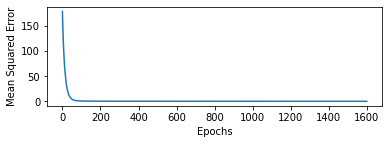

Testing
Testing Error is  0.24310860078286026


In [ ]:
GD5 = PolynomialRegression(5)
x_train_trans_5 = GD5.transform(train_X)
x_test_trans_5 = GD5.transform(test_X)
GD5.fit(x_train_trans_5, train_y,epochs = 1600, learning='GD', learning_rate=0.00002)
GD5.evaluate(x_test_trans_5,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD5.pickle', 'wb')
#  pickle.dump(GD5, file)
#  file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD5.pickle', 'rb')      #use this code
tempGD5 = pickle.load(file)
file.close()

In [ ]:
 wGD5 = tempGD5.w
 wGD5[0]

array([-1.39400410e-01,  1.22376663e+00,  6.68328624e-01, -2.15021811e-01,
       -5.35380199e-01, -1.05396841e-03, -1.41134006e+00, -1.76673625e-01,
        8.93349524e-01,  1.01263168e+00,  3.09381479e-01, -1.68252774e-01,
       -5.73177654e-01, -5.49729614e-01, -7.32780334e-01, -4.46406408e-02,
       -3.51884747e-01,  7.22904398e-02,  2.98277352e-01,  4.72844904e-01,
       -1.74580336e-01])

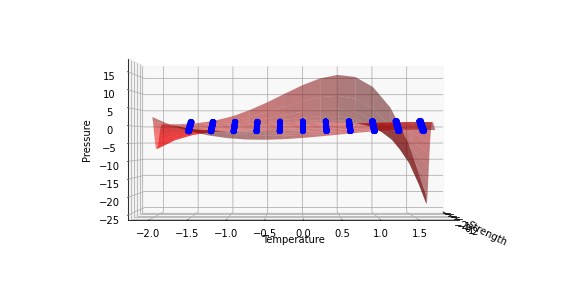

In [ ]:
# plot for 4 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD5[0],xx,yy,5)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(0,0) #(-30,0)

plt.show()

Training...


  0%|          | 0/15000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 341.2338693331314
Epoch: 50 Loss: 160.14931170117657
Epoch: 100 Loss: 20.474825872488655
Epoch: 150 Loss: 8.689965346471839
Epoch: 200 Loss: 10.845135225540188
Epoch: 250 Loss: 10.601982795223599
Epoch: 300 Loss: 2.13941548073727
Epoch: 350 Loss: 2.564451490367345
Epoch: 400 Loss: 1.703376020459104
Epoch: 450 Loss: 2.3445675825093453
Epoch: 500 Loss: 1.5873051920962622
Epoch: 550 Loss: 2.594079013672704
Epoch: 600 Loss: 3.948720281036699
Epoch: 650 Loss: 2.1390953686612604
Epoch: 700 Loss: 1.9275171751831022
Epoch: 750 Loss: 2.1617052433439796
Epoch: 800 Loss: 1.8804457347633774
Epoch: 850 Loss: 2.2668488804560067
Epoch: 900 Loss: 1.1390850159465222
Epoch: 950 Loss: 1.6966376020297484
Epoch: 1000 Loss: 23.82436757436851
Epoch: 1050 Loss: 2.3307512367814276
Epoch: 1100 Loss: 108.28630062308633
Epoch: 1150 Loss: 49.57886026288154
Epoch: 1200 Loss: 5.505962307321583
Epoch: 1250 Loss: 3.735266952941284
Epoch: 1300 Loss: 1.3191514544623053
Epoch: 1350 Loss: 1.4242223009930728

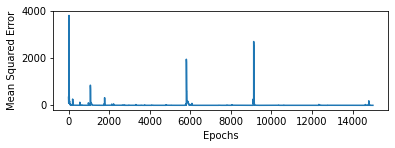

Testing
Testing Error is  0.3436110998981807


In [ ]:
SGD5 = PolynomialRegression(5)
x_train_trans_5 = SGD5.transform(train_X)
x_test_trans_5 = SGD5.transform(test_X)
SGD5.fit(x_train_trans_5, train_y,epochs = 15000, learning='SGD', learning_rate=0.00055)
SGD5.evaluate(x_test_trans_5,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/SGD5.pickle', 'wb')
#  pickle.dump(SGD5, file)
#  file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD5.pickle', 'rb')      #use this code
tempSGD5 = pickle.load(file)
file.close()

In [ ]:
 wSGD5 = tempSGD5.w
 wSGD5[0]

array([ 0.05214406,  0.95949348,  0.18504062,  0.70234679, -0.27444926,
       -0.46512233, -1.05672022,  0.01233823,  0.70244354,  0.60882477,
        0.090174  , -0.20089503, -0.89554359, -0.0319925 ,  0.58754868,
       -0.30683145, -0.41116448, -0.18761397,  0.19224532, -0.42705061,
        0.30161996])

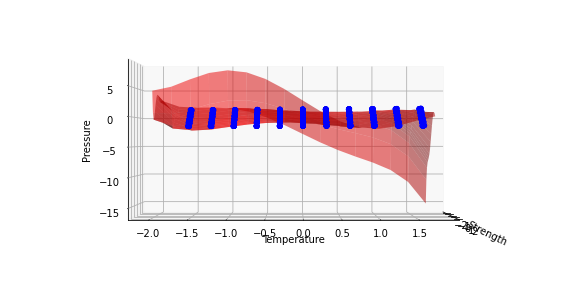

In [ ]:
# plot for 5 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD5[0],xx,yy,5)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(0,0) #(-30,0)

plt.show()

**6 Degree Polynomial**

Training...


  0%|          | 0/2500 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 348.3631663769241
Epoch: 50 Loss: 10.766551057557013
Epoch: 100 Loss: 2.160472342681156
Epoch: 150 Loss: 1.2537053024720946
Epoch: 200 Loss: 0.9401642887142072
Epoch: 250 Loss: 0.7595744217841007
Epoch: 300 Loss: 0.6414047246132792
Epoch: 350 Loss: 0.5592742614958647
Epoch: 400 Loss: 0.4998364894956587
Epoch: 450 Loss: 0.45551481293322255
Epoch: 500 Loss: 0.4216670600056526
Epoch: 550 Loss: 0.39528495285414195
Epoch: 600 Loss: 0.37433772786178754
Epoch: 650 Loss: 0.3574132353293408
Epoch: 700 Loss: 0.3435079599502579
Epoch: 750 Loss: 0.33189715033131334
Epoch: 800 Loss: 0.3220508425986437
Epoch: 850 Loss: 0.31357763625713403
Epoch: 900 Loss: 0.30618602880103507
Epoch: 950 Loss: 0.29965727760833066
Epoch: 1000 Loss: 0.2938260556053406
Epoch: 1050 Loss: 0.28856649942990453
Epoch: 1100 Loss: 0.2837820560475416
Epoch: 1150 Loss: 0.2793980422415274
Epoch: 1200 Loss: 0.2753561624728712
Epoch: 1250 Loss: 0.27161045221661684
Epoch: 1300 Loss: 0.2681242656076275
Epoch: 1350 Loss:

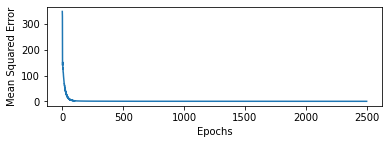

Testing
Testing Error is  0.23972206869894122


In [ ]:
GD6 = PolynomialRegression(6)
x_train_trans_6 = GD6.transform(train_X)
x_test_trans_6 = GD6.transform(test_X)
GD6.fit(x_train_trans_6, train_y,epochs = 2500, learning='GD', learning_rate=0.00002)
GD6.evaluate(x_test_trans_6,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD6.pickle', 'wb')
#  pickle.dump(GD6, file)
#  file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD6.pickle', 'rb')      #use this code
tempGD6 = pickle.load(file)
file.close()

In [ ]:
 wGD6 = tempGD6.w
 wGD6[0]

array([ 0.03663155,  1.1089299 ,  0.01437818,  0.30389633, -0.27725523,
       -0.11835994,  0.27602862, -1.4760272 ,  0.62129282,  0.30077352,
       -0.59436472,  0.12638175, -0.6655345 , -0.497916  , -0.13029079,
        1.12173428, -0.52463029,  0.74191329, -0.22243345, -0.74019578,
        0.95327455, -0.0953147 ,  0.28018542, -0.80074483, -0.25861009,
        0.27726052,  0.07681093,  0.00429753])

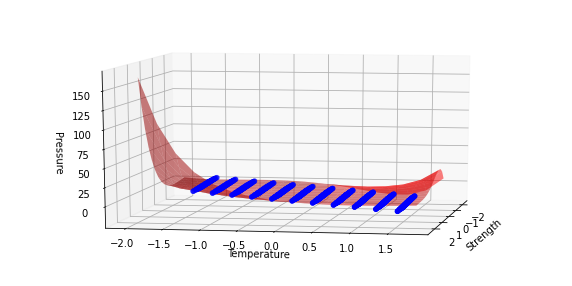

In [ ]:
# plot for 5 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD6[0],xx,yy,6)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,10) #(-30,0)

plt.show()

Training...


  0%|          | 0/40000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 421.2156450891126
Epoch: 50 Loss: 231.81987073518238
Epoch: 100 Loss: 77.44904461449849
Epoch: 150 Loss: 61.84350220272179
Epoch: 200 Loss: 3879.4088084950045
Epoch: 250 Loss: 318.25088304440413
Epoch: 300 Loss: 44.94427671586519
Epoch: 350 Loss: 26.80891946993891
Epoch: 400 Loss: 18.571560816360616
Epoch: 450 Loss: 19.848534074163602
Epoch: 500 Loss: 15.621073178261678
Epoch: 550 Loss: 15.516454542024496
Epoch: 600 Loss: 13.210001141658132
Epoch: 650 Loss: 11.442875293092584
Epoch: 700 Loss: 10.886084866475215
Epoch: 750 Loss: 16.435051952620135
Epoch: 800 Loss: 9.693194254047212
Epoch: 850 Loss: 8.341021204622466
Epoch: 900 Loss: 8.232021486043188
Epoch: 950 Loss: 30.61180155077285
Epoch: 1000 Loss: 15.694766889414417
Epoch: 1050 Loss: 8.86883296792573
Epoch: 1100 Loss: 7.103120188162816
Epoch: 1150 Loss: 7.064132991931759
Epoch: 1200 Loss: 6.95247073607578
Epoch: 1250 Loss: 8.226992051423057
Epoch: 1300 Loss: 8.959105919080496
Epoch: 1350 Loss: 6.268065656384952
Epoch

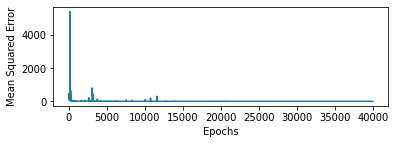

Testing
Testing Error is  0.5518572797589216


In [ ]:
SGD6 = PolynomialRegression(6)
x_train_trans_6 = SGD6.transform(train_X)
x_test_trans_6 = SGD6.transform(test_X)
SGD6.fit(x_train_trans_6, train_y,epochs = 40000, learning='SGD', learning_rate=0.00008)  # 25k for 0.0001
SGD6.evaluate(x_test_trans_6,test_y)

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD6.pickle', 'wb')
pickle.dump(SGD6, file)
file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD6.pickle', 'rb')      #use this code
tempSGD6 = pickle.load(file)
file.close()

In [ ]:
 wSGD6 = tempSGD6.w
 wSGD6[0]

array([ 0.40517148,  0.52800604, -0.37274423, -1.03136195, -0.15348897,
        0.64041357,  0.16576857, -0.49638569,  0.50109306,  0.7179915 ,
        0.54588927, -0.34761627, -0.43713733, -1.07085071, -0.13823222,
       -0.65443847, -0.66940823,  0.13682057, -0.21602724,  1.26016536,
        0.8466964 ,  0.22577725, -0.26075492, -0.29379926, -0.00629334,
        0.03473256, -0.40792832,  0.17608955])

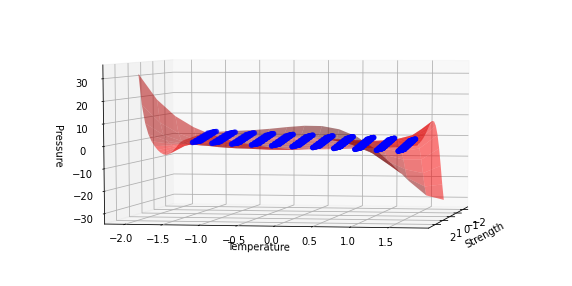

In [ ]:
# plot for 6 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD6[0],xx,yy,6)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(5,10) #(-30,0)

plt.show()

**7 Degree Polynomial**




Training...


  0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 7248.173821964426
Epoch: 50 Loss: 6.138928234371832
Epoch: 100 Loss: 3.096182448766442
Epoch: 150 Loss: 2.2165081254474512
Epoch: 200 Loss: 1.8370638501448557
Epoch: 250 Loss: 1.64322736225377
Epoch: 300 Loss: 1.526071746862595
Epoch: 350 Loss: 1.4427296192299601
Epoch: 400 Loss: 1.3756061950257108
Epoch: 450 Loss: 1.3172364247766204
Epoch: 500 Loss: 1.2643212411054525
Epoch: 550 Loss: 1.2153194485402508
Epoch: 600 Loss: 1.1694537212844351
Epoch: 650 Loss: 1.1262900731972996
Epoch: 700 Loss: 1.0855549684460564
Epoch: 750 Loss: 1.0470534236838047
Epoch: 800 Loss: 1.0106312555667005
Epoch: 850 Loss: 0.976157197224025
Epoch: 900 Loss: 0.9435142082632324
Epoch: 950 Loss: 0.9125951397005031
Epoch: 1000 Loss: 0.8833004974899359
Epoch: 1050 Loss: 0.8555372272021643
Epoch: 1100 Loss: 0.829217996725351
Epoch: 1150 Loss: 0.8042607210640251
Epoch: 1200 Loss: 0.7805882044248211
Epoch: 1250 Loss: 0.7581278396935152
Epoch: 1300 Loss: 0.7368113375022302
Epoch: 1350 Loss: 0.716574472729

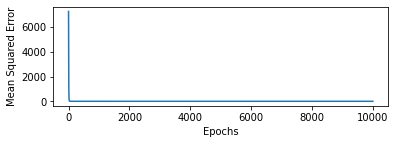

Testing
Testing Error is  0.2640681367125397


In [ ]:
GD7 = PolynomialRegression(7)
x_train_trans_7 = GD7.transform(train_X)
x_test_trans_7 = GD7.transform(test_X)
GD7.fit(x_train_trans_7, train_y,epochs = 10000, learning='GD', learning_rate=0.000005) 
GD7.evaluate(x_test_trans_7,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD7.pickle', 'wb')
#  pickle.dump(GD7, file)
#  file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD7.pickle', 'rb')      #use this code
tempGD7 = pickle.load(file)
file.close()

In [ ]:
 wGD7 = tempGD7.w
 wGD7[0]

array([ 0.06147591,  1.08296382,  0.59853033, -0.45391578, -1.57618392,
        1.08269756,  0.54611307, -0.34810869, -1.1651031 ,  0.46270509,
        0.17677442,  1.48242502, -0.63554066, -0.76904359,  0.28930687,
       -0.50992969,  0.25050336, -0.70512783, -0.09004684,  0.72437853,
       -0.45471721, -0.69407026, -0.11235802, -0.24450822, -0.31185336,
        1.17980194,  0.24980375,  0.17341421, -0.31872076, -0.89436162,
        0.23023994,  0.46284016, -0.04819798, -0.16485188,  0.26038939,
       -0.08835273])

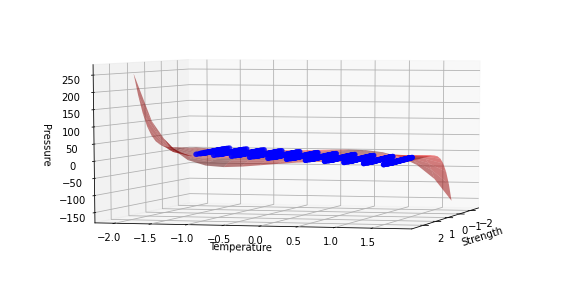

In [ ]:
# plot for 7 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD7[0],xx,yy,7)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(5,15) #(-30,0)

plt.show()

Training...


  0%|          | 0/150000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 127.71446843705489
Epoch: 50 Loss: 28.857847343941373
Epoch: 100 Loss: 34.094864338648556
Epoch: 150 Loss: 33.62159432131449
Epoch: 200 Loss: 20.00772421850291
Epoch: 250 Loss: 22.823055987890687
Epoch: 300 Loss: 19.9848405878603
Epoch: 350 Loss: 26.02137599819266
Epoch: 400 Loss: 19.27494451913996
Epoch: 450 Loss: 21.22823222208116
Epoch: 500 Loss: 18.416768421678192
Epoch: 550 Loss: 18.02150015507229
Epoch: 600 Loss: 18.716879128377133
Epoch: 650 Loss: 17.912336629039636
Epoch: 700 Loss: 19.78099117764392
Epoch: 750 Loss: 20.415587122401927
Epoch: 800 Loss: 23.807013726705218
Epoch: 850 Loss: 34.488393796260894
Epoch: 900 Loss: 29.269046093753115
Epoch: 950 Loss: 19.869706711755686
Epoch: 1000 Loss: 18.291381780091267
Epoch: 1050 Loss: 228.6963522804537
Epoch: 1100 Loss: 27.54706418611476
Epoch: 1150 Loss: 20.21219425698036
Epoch: 1200 Loss: 16.28327142135968
Epoch: 1250 Loss: 15.680620932089186
Epoch: 1300 Loss: 16.19051453449374
Epoch: 1350 Loss: 16.02860223895898
Ep

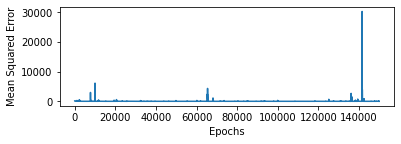

Testing
Testing Error is  0.7449599379511591


In [ ]:
SGD7 = PolynomialRegression(7)
x_train_trans_7 = SGD7.transform(train_X)
x_test_trans_7 = SGD7.transform(test_X)
SGD7.fit(x_train_trans_7, train_y,epochs = 150000, learning='SGD', learning_rate=0.000015)  #0.0000087 do 1 lakh epochs
SGD7.evaluate(x_test_trans_7,test_y)

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD7.pickle', 'wb')
pickle.dump(SGD7, file)
file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/SGD7.pickle', 'rb')      #use this code
tempSGD7 = pickle.load(file)
file.close()

In [ ]:
 wSGD7 = tempSGD7.w
 wSGD7[0]

array([ 0.06507475,  0.29349501, -0.44715808,  1.14667754,  1.41550469,
       -0.05569721, -0.21482285, -0.14258236, -0.54160584, -1.50950404,
       -0.52004241, -1.29284487, -0.37524677, -0.0062528 ,  0.80502371,
        0.91380633,  0.18806591,  0.05727465,  0.2294437 ,  0.10171069,
       -1.85083915, -1.27803852, -0.43197378,  0.28963115, -0.32524865,
        1.28830968,  0.59226756,  0.11003638,  0.87196561,  0.52425994,
        0.20431314, -0.31342755, -0.76136405, -0.12167504, -0.1617874 ,
        0.18216645])

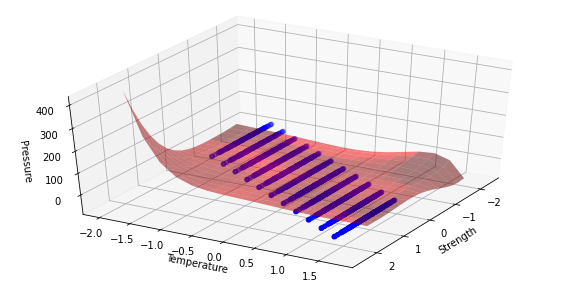

In [ ]:
# plot for 7 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wSGD7[0],xx,yy,7)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(40,30) #(-30,0)

plt.show()

**8 Degree Polynomial** [[NOT FINISHED]]

Training...


  0%|          | 0/20000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 990.9205803221237
Epoch: 50 Loss: 21.545599347624368
Epoch: 100 Loss: 11.973920879243567
Epoch: 150 Loss: 8.287725016995909
Epoch: 200 Loss: 6.344751577821114
Epoch: 250 Loss: 5.197601041177998
Epoch: 300 Loss: 4.478421171977474
Epoch: 350 Loss: 4.003320927316651
Epoch: 400 Loss: 3.6714424541586443
Epoch: 450 Loss: 3.4255708053235483
Epoch: 500 Loss: 3.232742817882385
Epoch: 550 Loss: 3.073767073007739
Epoch: 600 Loss: 2.9373514221080765
Epoch: 650 Loss: 2.8167608919009903
Epoch: 700 Loss: 2.7079012112975005
Epoch: 750 Loss: 2.6082153663718413
Epoch: 800 Loss: 2.516046793828126
Epoch: 850 Loss: 2.430271340169476
Epoch: 900 Loss: 2.350084297988117
Epoch: 950 Loss: 2.274876978136739
Epoch: 1000 Loss: 2.204164963433996
Epoch: 1050 Loss: 2.1375461653920373
Epoch: 1100 Loss: 2.0746760431107005
Epoch: 1150 Loss: 2.0152526905145023
Epoch: 1200 Loss: 1.959007593350353
Epoch: 1250 Loss: 1.9056996474435595
Epoch: 1300 Loss: 1.8551110628388057
Epoch: 1350 Loss: 1.8070443727365308
E

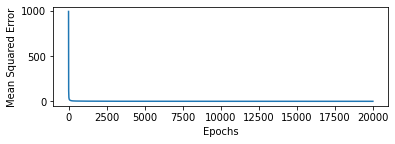

Testing
Testing Error is  0.30912875397404266


In [ ]:
GD8 = PolynomialRegression(8)
x_train_trans_8 = GD8.transform(train_X)
x_test_trans_8 = GD8.transform(test_X)
GD8.fit(x_train_trans_8, train_y,epochs = 20000, learning='GD', learning_rate=0.0000011)
GD8.evaluate(x_test_trans_8,test_y)

In [ ]:
  # file = open('/content/gdrive/My Drive/FODSAssignment/GD8.pickle', 'wb')
  # pickle.dump(GD8, file)
  # file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD8.pickle', 'rb')      #use this code
tempGD8 = pickle.load(file)
file.close()

In [ ]:
 wGD8 = tempGD8.w
 wGD8[0]

array([-0.22837551,  0.67870609,  0.90465846,  1.38171453,  0.45466376,
       -0.84477889, -0.53716487,  0.18402527,  0.23407155, -1.37842788,
       -0.93659433,  1.37465804, -0.82335738, -1.28458044, -0.51255562,
        0.16778802, -0.39955261, -0.13338043, -1.15589653,  0.29518773,
        0.51337914,  1.27048352,  0.13942905,  0.73966238, -0.18550086,
        0.89128756,  1.03054964, -0.56535172, -0.23232812, -0.5207525 ,
        0.19848538, -0.91745898, -0.09803752, -0.33180709,  0.36511478,
        0.36329596, -0.48371507,  0.69838561, -0.90915706,  0.1181868 ,
       -0.48298124,  0.87540964,  0.11252919, -0.17657267, -0.02882298])

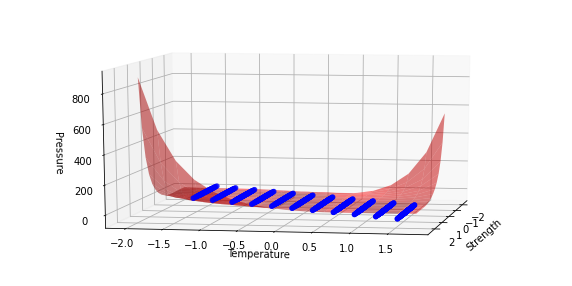

In [ ]:
# plot for 8 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD8[0],xx,yy,8)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(10,10) #(-30,0)

plt.show()

In [ ]:

SGD8 = PolynomialRegression(8)
x_train_trans_8 = SGD8.transform(train_X)
x_test_trans_8 = SGD8.transform(test_X)
SGD8.fit(x_train_trans_8, train_y,epochs = 500000, learning='SGD', learning_rate=0.000001)  #0.0000007
SGD8.evaluate(x_test_trans_8,test_y)

Training...


  0%|          | 0/500000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 76300 Loss: 4621.422796285353
Epoch: 76350 Loss: 4829.390662989355
Epoch: 76400 Loss: 4325.010558648689
Epoch: 76450 Loss: 4174.043600975539
Epoch: 76500 Loss: 4336.866265143269
Epoch: 76550 Loss: 4377.248367872346
Epoch: 76600 Loss: 3959.812509266562
Epoch: 76650 Loss: 3146.0792622986974
Epoch: 76700 Loss: 1257.8870325257333
Epoch: 76750 Loss: 2060.7187935461166
Epoch: 76800 Loss: 644.5855083734516
Epoch: 76850 Loss: 941.5776417788503
Epoch: 76900 Loss: 259.49880578746144
Epoch: 76950 Loss: 181.8939882103901
Epoch: 77000 Loss: 194.90804537541086
Epoch: 77050 Loss: 205.03011238552568
Epoch: 77100 Loss: 213.03762497641148
Epoch: 77150 Loss: 102.12174475655296
Epoch: 77200 Loss: 101.95574759559383
Epoch: 77250 Loss: 54.29249018140763
Epoch: 77300 Loss: 67.32581258367811
Epoch: 77350 Loss: 67.14489114517976
Epoch: 77400 Loss: 61.74191442926211
Epoch: 77450 Loss: 41.22633150624156
Epoch: 77500 Loss: 53.143677761395544
Epoch: 77550 L

KeyboardInterrupt: ignored

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD8.pickle', 'wb')
# pickle.dump(SGD8, file)
# file.close()

**9 Degree Polynomial** [[NOT FINISHED]]

Training...


  0%|          | 0/40000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 37221.067574817964
Epoch: 50 Loss: 184.9841254099669
Epoch: 100 Loss: 36.37921730099147
Epoch: 150 Loss: 27.766373906686596
Epoch: 200 Loss: 27.520550148350193
Epoch: 250 Loss: 30.31193878945712
Epoch: 300 Loss: 33.22023433172469
Epoch: 350 Loss: 35.5068510763376
Epoch: 400 Loss: 37.03217094267572
Epoch: 450 Loss: 37.89443207117474
Epoch: 500 Loss: 38.24500428657141
Epoch: 550 Loss: 38.22521906776532
Epoch: 600 Loss: 37.94837482794395
Epoch: 650 Loss: 37.49912204850285
Epoch: 700 Loss: 36.93828286830483
Epoch: 750 Loss: 36.30850774725162
Epoch: 800 Loss: 35.63920352482203
Epoch: 850 Loss: 34.9503766467392
Epoch: 900 Loss: 34.25547044627825
Epoch: 950 Loss: 33.56339614360567
Epoch: 1000 Loss: 32.87995983900493
Epoch: 1050 Loss: 32.208853365323144
Epoch: 1100 Loss: 31.55233697630552
Epoch: 1150 Loss: 30.91170720116591
Epoch: 1200 Loss: 30.28761620950083
Epoch: 1250 Loss: 29.68028911624713
Epoch: 1300 Loss: 29.089671404512938
Epoch: 1350 Loss: 28.515528626512673
Epoch: 1400

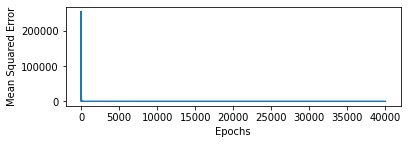

Testing
Testing Error is  0.41600579820683053


In [ ]:
GD9 = PolynomialRegression(9)
x_train_trans_9 = GD9.transform(train_X)
x_test_trans_9 = GD9.transform(test_X)
GD9.fit(x_train_trans_9, train_y,epochs = 40000, learning='GD', learning_rate=0.0000005)
GD9.evaluate(x_test_trans_9,test_y)

In [ ]:
#  file = open('/content/gdrive/My Drive/FODSAssignment/GD9.pickle', 'wb')
#  pickle.dump(GD9, file)
#  file.close()

In [ ]:
file = open('/content/gdrive/My Drive/FODSAssignment/GD9.pickle', 'rb')      #use this code
tempGD9 = pickle.load(file)
file.close()

In [ ]:
 wGD9 = tempGD9.w
 wGD9[0]

array([-0.32120612,  1.96472189,  0.28248809, -0.82556761,  0.24346896,
       -0.06211942,  0.30025056,  0.88333641, -0.16824011, -0.36989515,
       -0.97524462,  0.40385732, -1.57524381, -0.02840174, -0.36714779,
       -0.66095095, -0.15583816,  0.18782226,  0.55781616,  0.40145313,
       -0.45095378,  1.26459072, -0.38775787, -1.30261052,  0.68917431,
        0.35299423, -0.64228963, -0.25279832, -2.69003452,  0.36497414,
       -0.18970419,  1.86637703,  0.68095114, -0.88096556,  0.76594129,
        0.24985849,  1.19332772, -0.99910817, -0.70068981,  0.40349591,
        0.21313151,  0.4847628 , -0.14363654, -0.41325645,  0.95850726,
       -0.36794752, -0.43393403,  0.13180817, -0.74288717,  0.16936418,
        0.27399701, -0.01822998, -0.1168724 ,  0.19220988, -0.04657386])

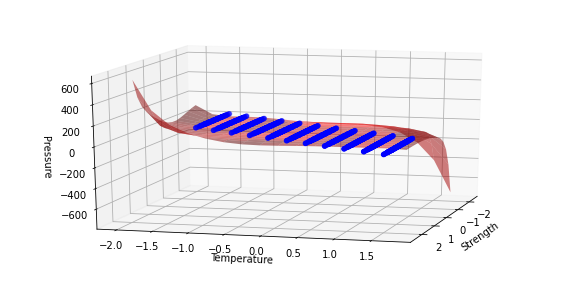

In [ ]:
# plot for 8 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
# find the z coordinate from the discriminant vector
Z=genCurve(wGD9[0],xx,yy,9)

ax.plot_surface(xx, yy, Z, alpha=0.5, color ='r')

ax.scatter3D(X[:,0], X[:,1], y, c='b')
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,15) #(-30,0)

plt.show()

In [ ]:
SGD9 = PolynomialRegression(9)
x_train_trans_9 = SGD9.transform(train_X)
x_test_trans_9 = SGD9.transform(test_X)
SGD9.fit(x_train_trans_9, train_y,epochs = 250000, learning='SGD', learning_rate=0.0000001)
SGD9.evaluate(x_test_trans_9,test_y)

Training...


  0%|          | 0/250000 [00:00<?, ?epoch/s]

Epoch: 0 Loss: 56.89294942625441
Epoch: 50 Loss: 21.99204681008068
Epoch: 100 Loss: 39.28821594515882
Epoch: 150 Loss: 32.940895262504526
Epoch: 200 Loss: 23.323302627197776
Epoch: 250 Loss: 21.01109351618413
Epoch: 300 Loss: 20.16428298248995
Epoch: 350 Loss: 20.118769771362174
Epoch: 400 Loss: 19.851678081707906
Epoch: 450 Loss: 19.930153649653317
Epoch: 500 Loss: 21.382334987537295
Epoch: 550 Loss: 38.79673263963309
Epoch: 600 Loss: 29.988191172349076
Epoch: 650 Loss: 26.67227124596908
Epoch: 700 Loss: 21.779925875060265
Epoch: 750 Loss: 21.337850466632034
Epoch: 800 Loss: 21.396731820317086
Epoch: 850 Loss: 21.032740702560076
Epoch: 900 Loss: 20.777941100101128
Epoch: 950 Loss: 20.812955996421714
Epoch: 1000 Loss: 19.672079298201346
Epoch: 1050 Loss: 20.334533340113484
Epoch: 1100 Loss: 18.996722760325007
Epoch: 1150 Loss: 18.824838025116005
Epoch: 1200 Loss: 18.688160481313595
Epoch: 1250 Loss: 24.134893042637586
Epoch: 1300 Loss: 24.47478382097832
Epoch: 1350 Loss: 29.64462053594

KeyboardInterrupt: ignored

In [ ]:
# file = open('/content/gdrive/My Drive/FODSAssignment/SGD9.pickle', 'wb')
# pickle.dump(SGD9, file)
# file.close()

MODIFIED MODEL 2


In [ ]:
class PolynomialRegression():

    def __init__(self, degree):
        self.w = None
        #self.X_train, self.X_test, self.y_train, self.y_test = X_train,X_test,y_train, y_test
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degre d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int)
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):    
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/(len(y))

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        return (y_pred - y)*x

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)[0]
        print("Testing Error is ", test_loss)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):

        self.w = np.random.randn(1, X.shape[1])     

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        count=0
        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0

            if learning == 'GD':
                #for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)   
                    self.w -= learning_rate * (dw/X.shape[0])   

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)   
                self.w -= learning_rate * dw   

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]  
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")

        #self.evaluate(self.X_test,self.y_test)